In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

In [19]:
books = pd.read_csv("Books.csv")
ratings = pd.read_csv("Ratings.csv")

In [21]:
books.head()

,Title,description,authors,image,previewLink,publisher,publishedDate,infoLink,categories,ratingsCount
0,Its Only Art If Its Well Hung!,NaN,['Julie Strain'],http://books.google.com/books/content?id=DykPA...,http://books.google.nl/books?id=DykPAAAACAAJ&d...,NaN,1996,http://books.google.nl/books?id=DykPAAAACAAJ&d...,['Comics & Graphic Novels'],NaN
1,Dr. Seuss: American Icon,Philip Nel takes a fascinating look into the k...,['Philip Nel'],http://books.google.com/books/content?id=IjvHQ...,http://books.google.nl/books?id=IjvHQsCn_pgC&p...,A&C Black,2005-01-01,http://books.google.nl/books?id=IjvHQsCn_pgC&d...,['Biography & Autobiography'],NaN
2,Wonderful Worship in Smaller Churches,This resource includes twelve principles in un...,['David R. Ray'],http://books.google.com/books/content?id=2tsDA...,http://books.google.nl/books?id=2tsDAAAACAAJ&d...,NaN,2000,http://books.google.nl/books?id=2tsDAAAACAAJ&d...,['Religion'],NaN
3,Whispers of the Wicked Saints,Julia Thomas finds her life spinning out of co...,['Veronica Haddon'],http://books.google.com/books/content?id=aRSIg...,http://books.google.nl/books?id=aRSIgJlq6JwC&d...,iUniverse,2005-02,http://books.google.nl/books?id=aRSIgJlq6JwC&d...,['Fiction'],NaN
4,"Nation Dance: Religion, Identity and Cultural ...",NaN,['Edward Long'],NaN,http://books.google.nl/books?id=399SPgAACAAJ&d...,NaN,2003-03-01,http://books.google.nl/books?id=399SPgAACAAJ&d...,NaN,NaN


In [23]:
ratings.head()

,Id,Title,Price,User_id,profileName,review/helpfulness,review/score,review/time,review/summary,review/text
0,1882931173,Its Only Art If Its Well Hung!,NaN,AVCGYZL8FQQTD,"Jim of Oz ""jim-of-oz""",7/7,4.0,940636800,Nice collection of Julie Strain images,This is only for Julie Strain fans. It's a col...
1,0826414346,Dr. Seuss: American Icon,NaN,A30TK6U7DNS82R,Kevin Killian,10/10,5.0,1095724800,Really Enjoyed It,I don't care much for Dr. Seuss but after read...
2,0826414346,Dr. Seuss: American Icon,NaN,A3UH4UZ4RSVO82,John Granger,10/11,5.0,1078790400,Essential for every personal and Public Library,"If people become the books they read and if ""t..."
3,0826414346,Dr. Seuss: American Icon,NaN,A2MVUWT453QH61,"Roy E. Perry ""amateur philosopher""",7/7,4.0,1090713600,Phlip Nel gives silly Seuss a serious treatment,"Theodore Seuss Geisel (1904-1991), aka &quot;D..."
4,0826414346,Dr. Seuss: American Icon,NaN,A22X4XUPKF66MR,"D. H. Richards ""ninthwavestore""",3/3,4.0,1107993600,Good academic overview,Philip Nel - Dr. Seuss: American IconThis is b...


In [27]:
df = ratings.merge(
    books[['Title', 'authors', 'categories']], 
    on='Title', 
    how='left'
)
df.head()

,Id,Title,Price,User_id,profileName,review/helpfulness,review/score,review/time,review/summary,review/text,authors,categories
0,1882931173,Its Only Art If Its Well Hung!,NaN,AVCGYZL8FQQTD,"Jim of Oz ""jim-of-oz""",7/7,4.0,940636800,Nice collection of Julie Strain images,This is only for Julie Strain fans. It's a col...,['Julie Strain'],['Comics & Graphic Novels']
1,0826414346,Dr. Seuss: American Icon,NaN,A30TK6U7DNS82R,Kevin Killian,10/10,5.0,1095724800,Really Enjoyed It,I don't care much for Dr. Seuss but after read...,['Philip Nel'],['Biography & Autobiography']
2,0826414346,Dr. Seuss: American Icon,NaN,A3UH4UZ4RSVO82,John Granger,10/11,5.0,1078790400,Essential for every personal and Public Library,"If people become the books they read and if ""t...",['Philip Nel'],['Biography & Autobiography']
3,0826414346,Dr. Seuss: American Icon,NaN,A2MVUWT453QH61,"Roy E. Perry ""amateur philosopher""",7/7,4.0,1090713600,Phlip Nel gives silly Seuss a serious treatment,"Theodore Seuss Geisel (1904-1991), aka &quot;D...",['Philip Nel'],['Biography & Autobiography']
4,0826414346,Dr. Seuss: American Icon,NaN,A22X4XUPKF66MR,"D. H. Richards ""ninthwavestore""",3/3,4.0,1107993600,Good academic overview,Philip Nel - Dr. Seuss: American IconThis is b...,['Philip Nel'],['Biography & Autobiography']


In [29]:
def sentiment_label(score):
    if score >= 4:
        return "positive"
    elif score <= 2:
        return "negative"
    else:
        return "neutral"

df['sentiment'] = df['review/score'].apply(sentiment_label)
df['sentiment'].value_counts()


sentiment
positive    16094
negative     2309
neutral      1597
Name: count, dtype: int64

In [31]:
df = df[df['sentiment'] != 'neutral']

In [33]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z\s]', '', text)
    text = " ".join([w for w in text.split() if w not in stop_words])
    return text

df['clean_review'] = df['review/text'].apply(clean_text)
df[['review/text', 'clean_review']].head()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\moham\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,review/text,clean_review
0,This is only for Julie Strain fans. It's a col...,julie strain fans collection photos pages wort...
1,I don't care much for Dr. Seuss but after read...,dont care much dr seuss reading philip nels bo...
2,"If people become the books they read and if ""t...",people become books read child father man dr s...
3,"Theodore Seuss Geisel (1904-1991), aka &quot;D...",theodore seuss geisel aka quotdr seussquot one...
4,Philip Nel - Dr. Seuss: American IconThis is b...,philip nel dr seuss american iconthis basicall...


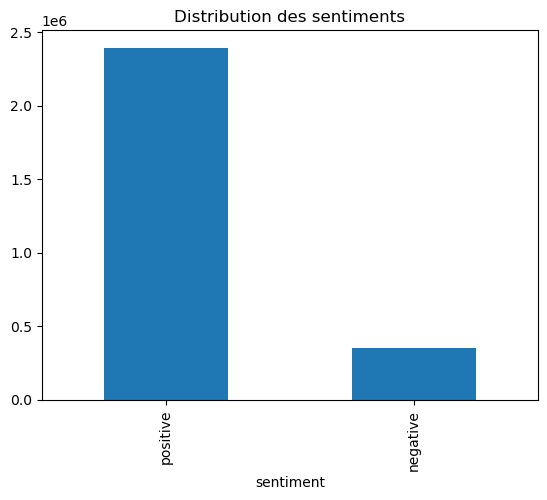

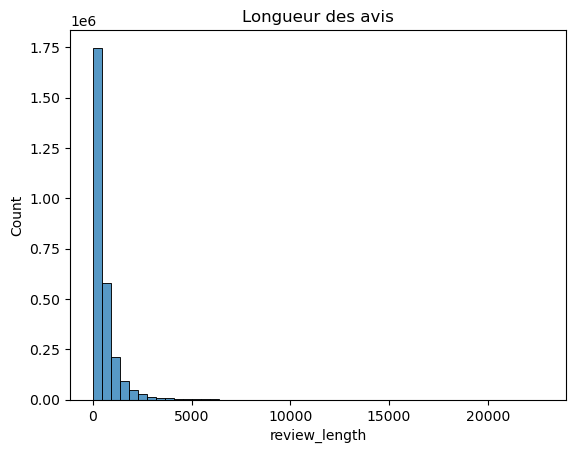

In [20]:
df['sentiment'].value_counts().plot(kind='bar')
plt.title("Distribution des sentiments")
plt.show()

df['review_length'] = df['clean_review'].apply(len)
sns.histplot(df['review_length'], bins=50)
plt.title("Longueur des avis")
plt.show()


In [39]:
X = df['clean_review']
y = df['sentiment']

In [41]:
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_tfidf = tfidf.fit_transform(X)

In [43]:
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42, stratify=y
)


In [45]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes": MultinomialNB(),
    "SVM (LinearSVC)": LinearSVC()
}


In [47]:
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "F1-score": f1_score(y_test, y_pred, average="weighted")
    })
    
    print(f"\n{name}")
    print(classification_report(y_test, y_pred))



Logistic Regression
              precision    recall  f1-score   support

    negative       0.86      0.27      0.41       462
    positive       0.90      0.99      0.95      3219

    accuracy                           0.90      3681
   macro avg       0.88      0.63      0.68      3681
weighted avg       0.90      0.90      0.88      3681


Naive Bayes
              precision    recall  f1-score   support

    negative       0.89      0.07      0.12       462
    positive       0.88      1.00      0.94      3219

    accuracy                           0.88      3681
   macro avg       0.88      0.53      0.53      3681
weighted avg       0.88      0.88      0.83      3681



C:\Users\moham\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(



SVM (LinearSVC)
              precision    recall  f1-score   support

    negative       0.70      0.50      0.59       462
    positive       0.93      0.97      0.95      3219

    accuracy                           0.91      3681
   macro avg       0.82      0.74      0.77      3681
weighted avg       0.90      0.91      0.90      3681



In [49]:
results_df = pd.DataFrame(results)
results_df.sort_values(by="F1-score", ascending=False)


,Model,Accuracy,F1-score
2,SVM (LinearSVC),0.911165,0.904714
0,Logistic Regression,0.902472,0.879294
1,Naive Bayes,0.881826,0.834736


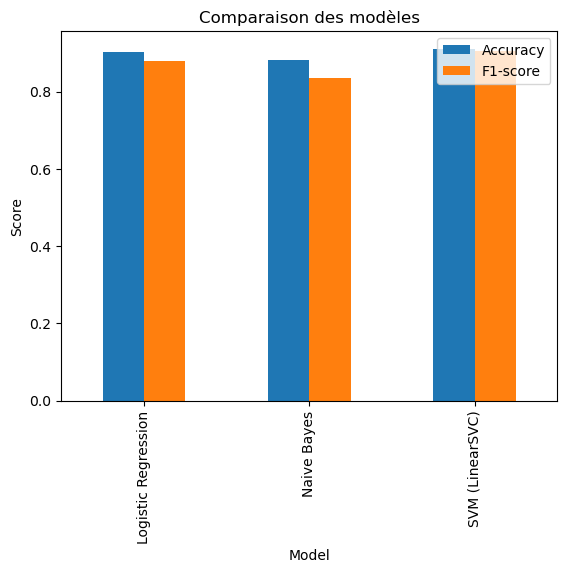

In [51]:
results_df.set_index("Model")[["Accuracy", "F1-score"]].plot(kind="bar")
plt.title("Comparaison des modèles")
plt.ylabel("Score")
plt.show()

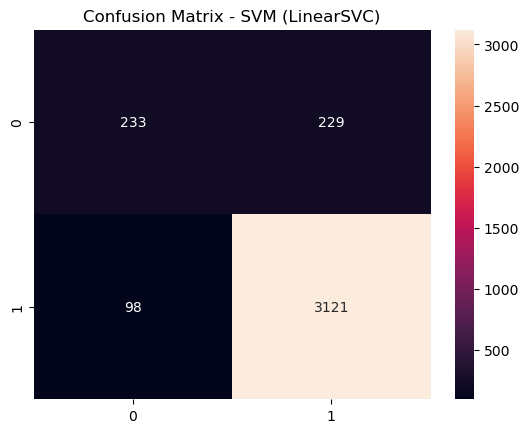

In [53]:
best_model_name = results_df.sort_values(
    by="F1-score", ascending=False
).iloc[0]['Model']

best_model = models[best_model_name]
y_pred_best = best_model.predict(X_test)

sns.heatmap(confusion_matrix(y_test, y_pred_best), annot=True, fmt='d')
plt.title(f"Confusion Matrix - {best_model_name}")
plt.show()
